# **SY23 Project**

# 1.introduction
This is my project which implements deep learning-based neural style migration, and uses the VGG19 model as a base network to extract content and style features from images. This function is to transform the target image into a target style of our choice (which can be various schools of oil paintings, comic book styles, etc. etc.)

# 2. Parameter settings

This block of code is mainly used for a variety of parameters, their functions please see the comments.

I provide two ways to determine the size of the generated image, one is that you can directly determine his length and width, the other is based on the content of the image you enter the multiplier scaling, you only need to decide the scaling multiplier (Exemple: 0.5 is half of the size of the original image)

In [11]:
# Specifies the network layers used for content representation and their weights in the total loss function.
CONTENT_LAYERS = {'block4_conv2': 0.5, 'block5_conv2': 0.5}
# Specifies the network layers used for style representation and their weights in the total loss function.
STYLE_LAYERS = {'block1_conv1': 0.2, 'block2_conv1': 0.2, 'block3_conv1': 0.2, 'block4_conv1': 0.2, 'block5_conv1': 0.2}


# Path to the content image
CONTENT_IMAGE_PATH = '/content/images/park.jpg'
# Path to the style image
STYLE_IMAGE_PATH = '/content/images/mn001.jpg'

# Directory for saving the generated images if you don't have it will create one for you
OUTPUT_DIR = '/content/output'

# Path of the model
MODEL_SAVE_PATH = '/content/model'

# Overall weighting coefficient for content loss
CONTENT_LOSS_FACTOR = 1
# Overall weighting coefficient for style loss
STYLE_LOSS_FACTOR = 10000


# Defines the size of the generated image.
# WIDTH = 640
# HEIGHT = 850
SIZE = 1


# Number of epochs for training
EPOCHS = 20
# Number of training steps per epoch
STEPS_PER_EPOCH = 100
# Learning rate
LEARNING_RATE = 0.03





# 3. Imports
This is the section that handles all references and dependencies

In [12]:
import typing
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import torch
import torch.nn as nn
from PIL import Image
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt



# 4. Image processing function

This part of the code is used to process, display and save the image, because this is just a style migration, so we only care about the size of the content image (aspect ratio) will not be compressed, the feature image only need to provide the features can be, and in order to facilitate the subsequent matrix arithmetic, we need to keep the features and the content are in one size, so that there will not be a dimensional mismatch of problems



In [13]:
# Mean and standard deviation for image normalization, usually from ImageNet statistics
image_mean = tf.constant([0.485, 0.456, 0.406])
image_std = tf.constant([0.299, 0.224, 0.225])

def normalization(x):
    """
    Normalizes the input image tensor 'x'.
    :param x: The input tensor representing the image.
    :return: The normalized image tensor.
    """
    return (x - image_mean) / image_std

def load_images(image_path, width, height):
    """
    Loads and processes an image from the specified path.
    :param image_path: The path to the image file.
    :param width: The desired width of the image.
    :param height: The desired height of the image.
    :return: A tensor representing the processed image.
    """
    x = tf.io.read_file(image_path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [height, width])
    x = x / 255.
    x = normalization(x)
    x = tf.reshape(x, [1, height, width, 3])
    return x

def load_width_and_weigth(image_path, size):
    """
    Loads an image and adjusts its width and height based on a scaling factor.
    :param image_path: The path to the image file.
    :param size: The scaling factor for adjusting the image size.
    :return: The adjusted height and width of the image.
    """
    img = tf.io.read_file(CONTENT_IMAGE_PATH)
    img_decoded = tf.image.decode_image(img)
    img_height, img_width = tf.shape(img_decoded)[0].numpy() * size, tf.shape(img_decoded)[1].numpy() * size
    img_width = int(img_width * size)
    img_height = int(img_height * size)
    return img_height, img_width

def save_image(image, filename):
    """
    Saves the given image tensor to a file.
    :param image: The image tensor to save.
    :param filename: The path where the image will be saved.
    """
    # Reshape the image to remove batch dimension
    x = tf.reshape(image, image.shape[1:])
    # Inverse the normalization
    x = x * image_std + image_mean
    x = x * 255.
    x = tf.cast(x, tf.int32)
    x = tf.clip_by_value(x, 0, 255)
    x = tf.cast(x, tf.uint8)
    x = tf.image.encode_jpeg(x)
    tf.io.write_file(filename, x)

def deprocess_img(img_tensor):
    """
    Denormalizes an image tensor and clips its values to ensure they are between 0 and 1.
    :param img_tensor: The image tensor to deprocess.
    :return: A deprocessed image tensor with values ranging from 0 to 1.
    """

    # First, expand the shape of the mean and std deviation tensors from [3] to [1, 1, 3]
    mean = tf.reshape(tf.constant([0.485, 0.456, 0.406]), (1, 1, 3))
    std = tf.reshape(tf.constant([0.229, 0.224, 0.225]), (1, 1, 3))

    # Denormalize the image data
    img_tensor = img_tensor * std + mean
    img_tensor = tf.clip_by_value(img_tensor, 0, 1)
    return img_tensor



def display_image(image, title=None):
    """
    Displays an image with an optional title.
    :param image: The image tensor to display.
    :param title: An optional title to display above the image.
    """

    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(deprocess_img(image))

    if title:
        plt.title(title)
    plt.show()


# 5. Model creation

This function is used to create a pre-trained VGG19 model that is modified to output layer-specific activation.

The following section is from the VGG19 presentation:

VGG19 has 19 layers, including 16 convolutional layers, 3 fully connected layers, and 5 pooling layers.

I only loaded the convolutional base of VGG19 and did not include the top fully connected layer because fully connected layers are mainly used for image classification tasks. And I redefined the layers used to process style and content; we generally use the shallower layer of each convolutional block for style and the deeper layer for content. You can find them in my 2. Parameter settings part.





In [14]:
def get_vgg19_model(layers):
    """
    Creates and initializes a VGG19 model.
    :param layers: A list of layer names in VGG19 to extract features from.
    :return: A modified VGG19 model that outputs the specified layers.
    """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    outputs = [vgg.get_layer(layer).output for layer in layers]
    model = tf.keras.Model([vgg.input, ], outputs)
    # Set the model parameters to non-trainable
    model.trainable = False
    return model

modelVGG = tf.keras.applications.VGG19()
for layer in modelVGG.layers:
    print(f'layer name: {layer.name}, layer type: {layer.__class__.__name__}')


layer name: input_3, layer type: InputLayer
layer name: block1_conv1, layer type: Conv2D
layer name: block1_conv2, layer type: Conv2D
layer name: block1_pool, layer type: MaxPooling2D
layer name: block2_conv1, layer type: Conv2D
layer name: block2_conv2, layer type: Conv2D
layer name: block2_pool, layer type: MaxPooling2D
layer name: block3_conv1, layer type: Conv2D
layer name: block3_conv2, layer type: Conv2D
layer name: block3_conv3, layer type: Conv2D
layer name: block3_conv4, layer type: Conv2D
layer name: block3_pool, layer type: MaxPooling2D
layer name: block4_conv1, layer type: Conv2D
layer name: block4_conv2, layer type: Conv2D
layer name: block4_conv3, layer type: Conv2D
layer name: block4_conv4, layer type: Conv2D
layer name: block4_pool, layer type: MaxPooling2D
layer name: block5_conv1, layer type: Conv2D
layer name: block5_conv2, layer type: Conv2D
layer name: block5_conv3, layer type: Conv2D
layer name: block5_conv4, layer type: Conv2D
layer name: block5_pool, layer type:

# 6. Implementing Neural Style Migration

The purpose of this class is to extract the content and style features of the input image and provide the required output for neural style migration.

This is a customised model that extracts content features for content images and style features for style images by specifying certain layers in the VGG19 network. This model adjusts an initial random image so that its content features are close to the content features of the content image while its style features are close to the style features of the style image. In this way, the model generates an image that is structurally similar to the content image, but is influenced by the style image in terms of colour, texture, etc.



In [15]:
class NeuralStyleTransferModel(tf.keras.Model):
    def __init__(self, content_layers: typing.Dict[str, float] = CONTENT_LAYERS,
                 style_layers: typing.Dict[str, float] = STYLE_LAYERS):
        """
        Initializes the Neural Style Transfer Model.
        :param content_layers: A dictionary of layer names and their corresponding weights for content representation.
        :param style_layers: A dictionary of layer names and their corresponding weights for style representation.
        """
        super(NeuralStyleTransferModel, self).__init__()
        # Dictionary of content feature layers and their weights
        self.content_layers = content_layers
        # Dictionary of style feature layers and their weights
        self.style_layers = style_layers
        # Extract all the VGG layers needed
        layers = list(self.content_layers.keys()) + list(self.style_layers.keys())
        # Create a map from layer names to their outputs' indices
        self.outputs_index_map = dict(zip(layers, range(len(layers))))
        # Create and initialize the VGG network
        self.vgg = get_vgg19_model(layers)

    def call(self, inputs, training=None, mask=None):
        """
        Forward pass of the model.
        :param inputs: Input tensor (image) for the model.
        :param training: Not used in this model as parameters are non-trainable.
        :param mask: Not used in this model.
        :return: A dictionary with two keys 'content' and 'style'. Each corresponds to a list of tuples (output, weight) for each specified layer in content_layers and style_layers.
        """
        # Get the outputs from the VGG model
        outputs = self.vgg(inputs)
        # Separate the content and style features
        content_outputs = []
        for layer, factor in self.content_layers.items():
            content_outputs.append((outputs[self.outputs_index_map[layer]][0], factor))
        style_outputs = []
        for layer, factor in self.style_layers.items():
            style_outputs.append((outputs[self.outputs_index_map[layer]][0], factor))
        # Return the outputs in a dictionary format
        return {'content': content_outputs, 'style': style_outputs}

# 7. Preparatory for the style migration

This part of the code implements the main process of neural style migration, including preparing the image data, calculating content and style losses, and defining the total loss function.



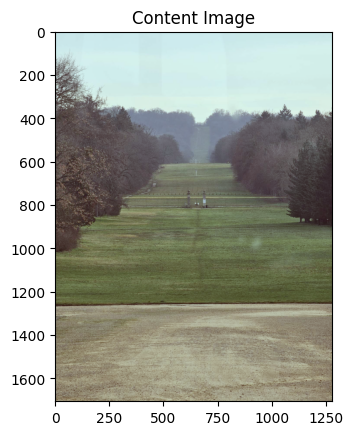

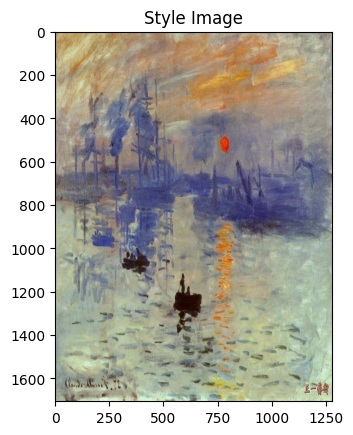

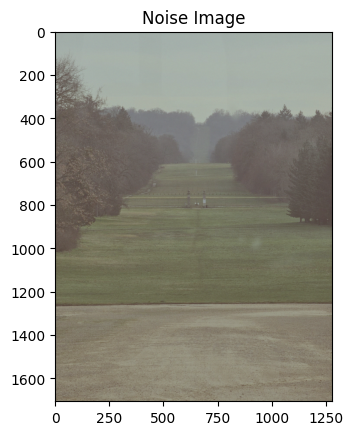

In [16]:
model = NeuralStyleTransferModel()

HEIGHT, WIDTH = load_width_and_weigth(CONTENT_IMAGE_PATH, SIZE)


content_image = load_images(CONTENT_IMAGE_PATH, WIDTH ,HEIGHT)
style_image = load_images(STYLE_IMAGE_PATH , WIDTH , HEIGHT)

# Obtain the content features for target content images
target_content_features = model([content_image, ])['content']
# Obtain the stylistic characteristics of the style image
target_style_features = model([style_image, ])['style']

M = WIDTH * HEIGHT
N = 3


def _compute_content_loss(noise_features, target_features):
    """
    Calculate the content loss between features of the noise image and the target content image for a specific layer.
    :param noise_features: Features of the noise image from a specific layer.
    :param target_features: Features of the content image from the same layer.
    :return: The content loss.
    """
    content_loss = tf.reduce_sum(tf.square(noise_features - target_features))
    # Normalize the loss
    x = 2. * M * N
    content_loss = content_loss / x
    return content_loss


def compute_content_loss(noise_content_features):
    """
    Calculate and return the total content loss for the current image.
    :param noise_content_features: Content features of the noise image.
    """
    content_losses = []
    # Compute weighted content loss for each layer
    for (noise_feature, factor), (target_feature, _) in zip(noise_content_features, target_content_features):
        layer_content_loss = _compute_content_loss(noise_feature, target_feature)
        content_losses.append(layer_content_loss * factor)
    return tf.reduce_sum(content_losses)


def gram_matrix(feature):
    """
    Compute the Gram matrix of a given feature map.
    """
    # Transpose the dimensions to bring the channel to the front
    x = tf.transpose(feature, perm=[2, 0, 1])
    # Flatten the feature map
    x = tf.reshape(x, (x.shape[0], -1))
    # Compute the product of the matrix and its transpose
    return x @ tf.transpose(x)


def _compute_style_loss(noise_feature, target_feature):
    """
    Calculate the style loss between features of the noise image and the style image for a specific layer.
    :param noise_feature: Style features of the noise image from a specific layer.
    :param target_feature: Style features of the style image from the same layer.
    """
    noise_gram_matrix = gram_matrix(noise_feature)
    style_gram_matrix = gram_matrix(target_feature)
    style_loss = tf.reduce_sum(tf.square(noise_gram_matrix - style_gram_matrix))
    # Normalize the loss
    x = 4. * (M ** 2) * (N ** 2)
    return style_loss / x


def compute_style_loss(noise_style_features):
    """
    Calculate and return the total style loss for the current image.
    :param noise_style_features: Style features of the noise image.
    """
    style_losses = []
    for (noise_feature, factor), (target_feature, _) in zip(noise_style_features, target_style_features):
        layer_style_loss = _compute_style_loss(noise_feature, target_feature)
        style_losses.append(layer_style_loss * factor)
    return tf.reduce_sum(style_losses)


def total_loss(noise_features):
    """
    Calculate the total loss (content + style) for the current image.
    :param noise_features: Features of the noise image.
    """
    content_loss = compute_content_loss(noise_features['content'])
    style_loss = compute_style_loss(noise_features['style'])
    return content_loss * CONTENT_LOSS_FACTOR + style_loss * STYLE_LOSS_FACTOR


# Set up the optimizer for the training process
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)


# Display the content and style images
display_image(content_image, "Content Image")
display_image(style_image, "Style Image")

# Generate a noise image based on the content image
noise_image = tf.Variable((content_image + np.random.uniform(-0.2, 0.2, (1, HEIGHT, WIDTH, 3))) / 2)
display_image(noise_image, "Noise Image")



# 8. Training

This code is used to train a model that optimises the generated image to be close to the target content image in terms of content and close to the target style image in terms of style.

Here I use @tf.function decorator for compiling functions into callable TensorFlow graphs for speeding up each training session.

Also train according to the initially set number of training rounds as well as the number of steps per round, and show the style-shifted image after each round is finish.

Epoch 1/20: 100%|██████████| 100/100 [01:44<00:00,  1.23it/s, loss=188625.5000]

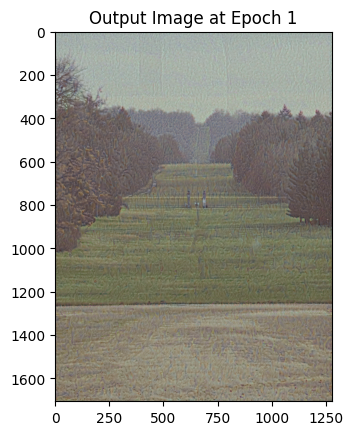

Epoch 2/20: 100%|██████████| 100/100 [01:24<00:00,  1.15it/s, loss=110674.7500]

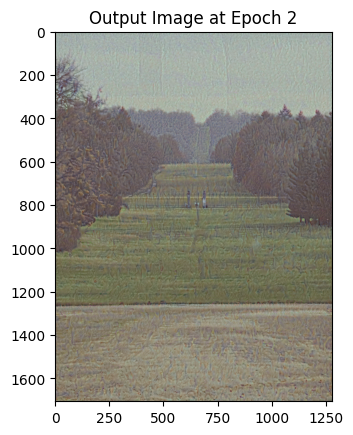

Epoch 3/20: 100%|██████████| 100/100 [01:25<00:00,  1.13it/s, loss=114097.5547]

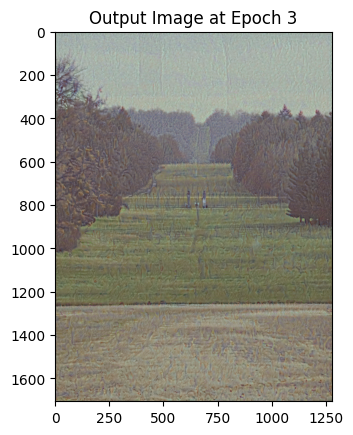

Epoch 4/20: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=97849.2969]

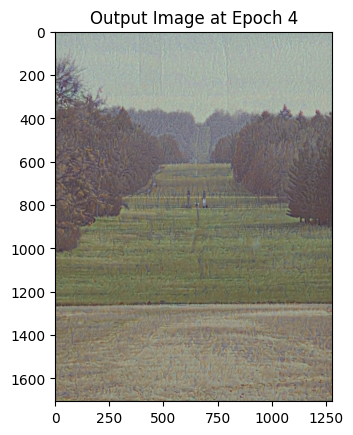

Epoch 5/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=168072.7969]

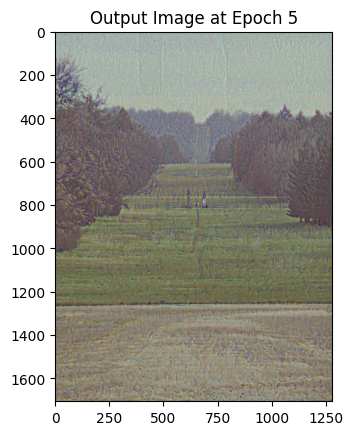

Epoch 6/20: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=63444.5898]

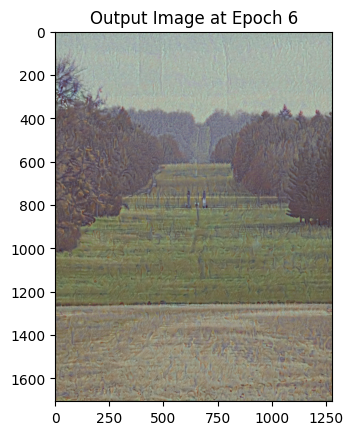

Epoch 7/20: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s, loss=53980.2695]

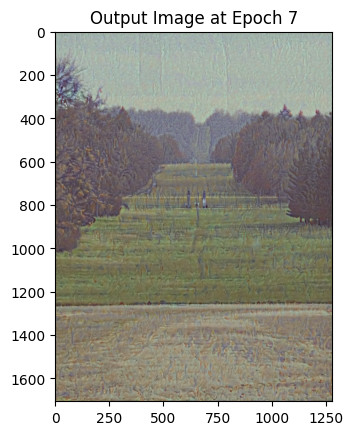

Epoch 8/20: 100%|██████████| 100/100 [01:26<00:00,  1.17it/s, loss=95592.3359]

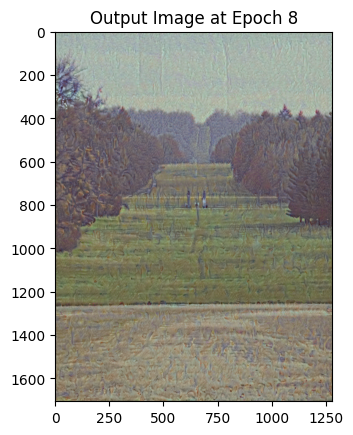

Epoch 9/20: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=102963.7188]

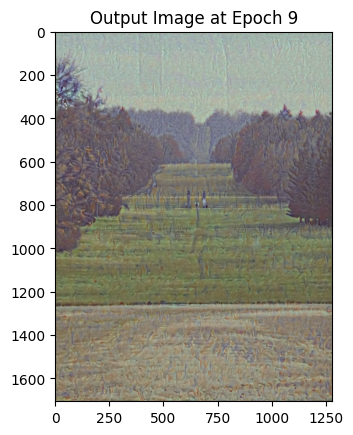

Epoch 10/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=45959.3438]

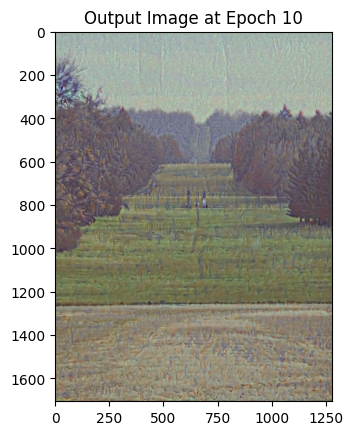

Epoch 11/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=133312.5156]

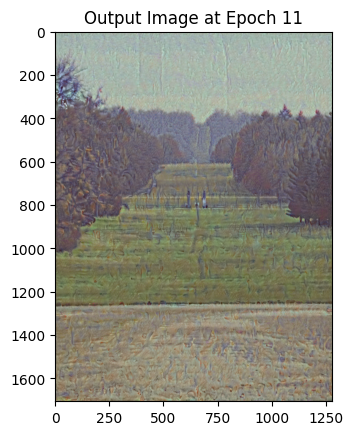

Epoch 12/20: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, loss=44016.0117]

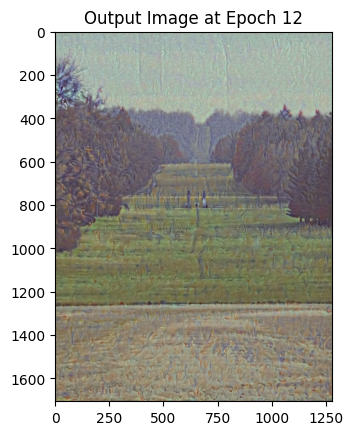

Epoch 13/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=36665.1758]

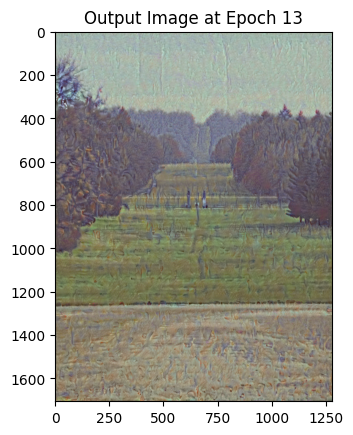

Epoch 14/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=173559.9062]

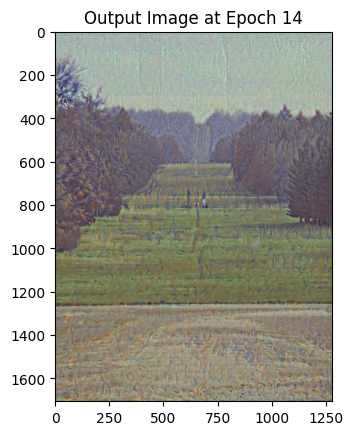

Epoch 15/20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=66345.9062]

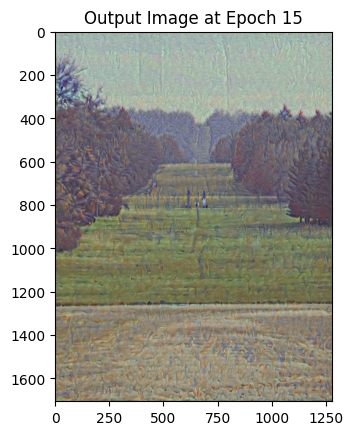

Epoch 16/20: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, loss=41288.3594]

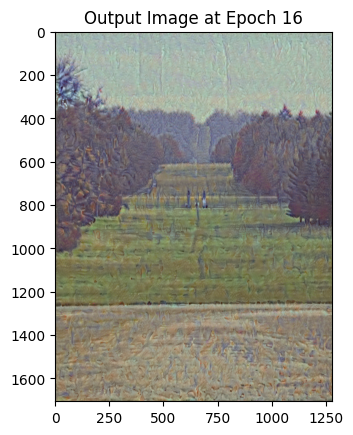

Epoch 17/20: 100%|██████████| 100/100 [01:26<00:00,  1.17it/s, loss=43318.6484]

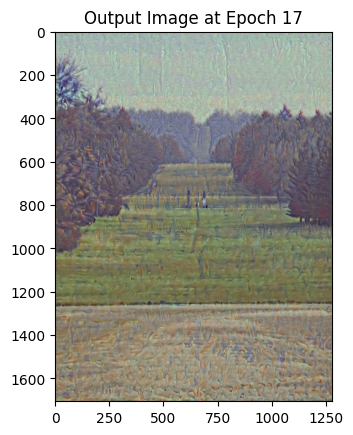

Epoch 18/20: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s, loss=105585.1016]

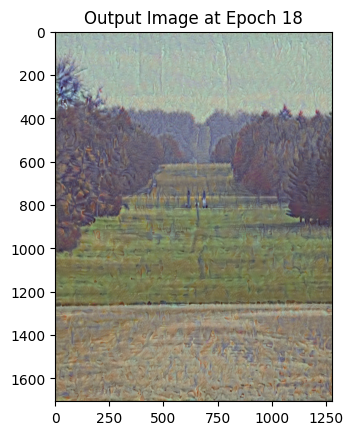

Epoch 19/20: 100%|██████████| 100/100 [01:26<00:00,  1.18it/s, loss=62625.9453]

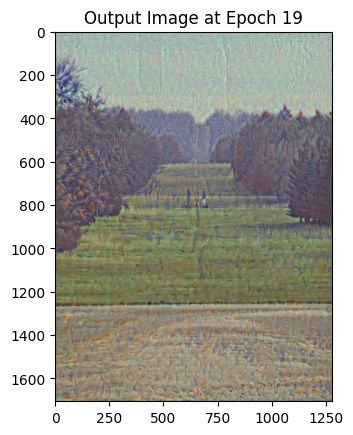

Epoch 20/20: 100%|██████████| 100/100 [01:26<00:00,  1.18it/s, loss=32163.4629]

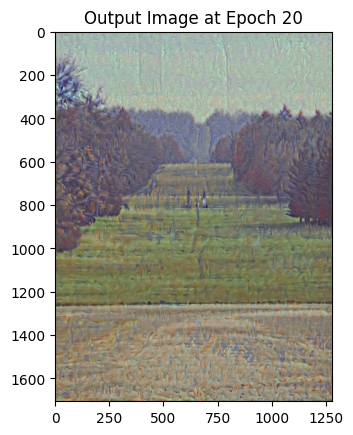

Epoch 20/20: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s, loss=32163.4629]


In [17]:
# Use tf.function to speed up training
@tf.function
def train_one_step():
    """
    Perform one iteration of the training process.
    """
    # Calculate the loss
    with tf.GradientTape() as tape:
        noise_outputs = model(noise_image)
        loss = total_loss(noise_outputs)
    # Compute gradients
    grad = tape.gradient(loss, noise_image)
    # Apply gradients (gradient descent) to update the noise image
    optimizer.apply_gradients([(grad, noise_image)])
    return loss


# Create a directory to save generated images
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# Determine how many rounds to train and how many times per round based
for epoch in range(EPOCHS):
    # Use tqdm to display training progress
    with tqdm(total=STEPS_PER_EPOCH, desc='Epoch {}/{}'.format(epoch + 1, EPOCHS)) as pbar:
        for step in range(STEPS_PER_EPOCH):
            _loss = train_one_step()
            pbar.set_postfix({'loss': '%.4f' % float(_loss)})
            pbar.update(1)
        # After each epoch, display and save the current version of the stylized image
        display_image(noise_image, f"Output Image at Epoch {epoch+1}")
        save_image(noise_image, '{}/{}.jpg'.format(OUTPUT_DIR, epoch + 1))

# 9. Save Model

This is the last section used to save the trained model for other operations later on.

In [18]:
if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)
# save the model
model.save(MODEL_SAVE_PATH)